# Topic Modelling

In [60]:
import os
import re
import pickle

from pprint import pprint
import numpy as np
import pandas as pd
from konlpy.tag import Komoran
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

from src.env import PROJECT_DIR

In [5]:
with open(PROJECT_DIR / 'data' / 'interim' / 'all_articles_1.pkl', 'rb') as fp:
    dfs = pickle.load(fp)

형태소 분석기 확인

In [6]:
komo = Komoran()

In [45]:
komo.morphs('이는 경기도가 부동산 안정화의 해법으로 수차례 강조한 ‘경기도 기본주택 공급’과 ‘기본소득토지세 신설’ 등 부동산 정책들이 신뢰를 갖도록 하는 사전 포석으로 풀이된다.')

['이',
 '는',
 '경기도',
 '가',
 '부동산',
 '안정',
 '화',
 '의',
 '해법',
 '으로',
 '수차례',
 '강조',
 '하',
 'ㄴ',
 '‘',
 '경기도',
 '기본',
 '주택',
 '공급',
 '’',
 '과',
 '‘',
 '기본소득',
 '토지세',
 '신설',
 '’',
 '등',
 '부동산',
 '정책',
 '들',
 '이',
 '신뢰',
 '를',
 '갖',
 '도록',
 '하',
 '는',
 '사전',
 '포석',
 '으로',
 '풀이',
 '되',
 'ㄴ다',
 '.']

In [7]:
for k, v in dfs.items():
    dfs[k].drop(['nouns'], axis=1, inplace=True)
    dfs[k].loc[:, 'morphs'] = v.text.apply(komo.morphs)

In [9]:
with open(PROJECT_DIR / 'data' / 'processed' / 'all_articles_1-morphs.pkl', 'wb') as fp:
    pickle.dump(dfs, fp)

In [38]:
all_docs_tokenized_before = []
all_docs_tokenized_after = []
split_date = pd.Timestamp(2020, 2, 25)
for k, v in dfs.items():
    all_docs_tokenized_before.extend(v.morphs[v.index < split_date].tolist())
    all_docs_tokenized_after.extend(v.morphs[v.index >= split_date].tolist())

In [71]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.4, min_df=10, max_features=2000)

In [72]:
dtm_tfidf = tfidf_vectorizer.fit_transform([' '.join(x) for x in all_docs_tokenized])

In [73]:
dtm_tfidf_before = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_before])
dtm_tfidf_after = tfidf_vectorizer.transform([' '.join(x) for x in all_docs_tokenized_after])

In [74]:
with open("tfidf-max_features-2000-max_df-0.5-min_df-10.pkl", "wb") as fp:
    pickle.dump(tfidf_vectorizer, fp)

In [75]:
print(dtm_tfidf.shape)

(2060, 2000)


# LDA

In [76]:
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [77]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.053020  0.064719       1        1  65.811710
10     0.229092  0.166212       2        1  17.902090
7     -0.276109  0.201250       3        1   5.532319
18    -0.189307 -0.119482       4        1   1.134071
15     0.169329 -0.138394       5        1   1.045053
3     -0.004162 -0.209720       6        1   0.977194
11    -0.108675 -0.023316       7        1   0.744749
16     0.018940 -0.058914       8        1   0.619457
12    -0.016110  0.066092       9        1   0.610612
6      0.049226 -0.003660      10        1   0.569476
19     0.016453  0.008787      11        1   0.519539
4     -0.000528  0.008467      12        1   0.514947
2      0.007908  0.010408      13        1   0.510261
8      0.004704  0.001095      14        1   0.507942
9      0.005490  0.005850      15        1   0.507622
5      0.008146  0.004121      16        1   0.498592
13     0.008146  0.004121      17        1   0.498592
14     0.008146  0.004121      18        1   0.498592
17     0.008146  0.004121      19        1   0.498592
0      0.008146  0.004121      20        1   0.498592, topic_info=     Term       Freq      Total Category  logprob  loglift
1068  습니다  39.000000  39.000000  Default  30.0000  30.0000
108   ㅂ니다  37.000000  37.000000  Default  29.0000  29.0000
1118   실험  32.000000  32.000000  Default  28.0000  28.0000
1507   재난  99.000000  99.000000  Default  27.0000  27.0000
1664   지사  60.000000  60.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
1849   판결   0.046085   5.280001  Topic20  -7.6009   0.5599
1009  세계화   0.046085   5.659429  Topic20  -7.6009   0.4905
270   공직자   0.046085   4.295693  Topic20  -7.6009   0.7663
772    발의   0.046085   5.194307  Topic20  -7.6009   0.5763
436    납부   0.046085   4.237991  Topic20  -7.6009   0.7798

[1039 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.429137  100
0         2  0.536421  100
2         1  0.401653  10대
2         9  0.401653  10대
16        1  0.524072   1월
...     ...       ...  ...
1975      2  0.247986   환수
1975      5  0.371979   환수
1990      1  0.329626   후보
1990      3  0.659252   후보
1998      1  0.880457   희생

[841 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 8, 19, 16, 4, 12, 17, 13, 7, 20, 5, 3, 9, 10, 6, 14, 15, 18, 1])

We should extract topics first, then see how many articles were written before vs. after COVID.

# NMF

In [78]:
nmf_tfidf = NMF(n_components=20, random_state=0)
nmf_tfidf.fit(dtm_tfidf)
pyLDAvis.sklearn.prepare(nmf_tfidf, dtm_tfidf, tfidf_vectorizer, mds='mmds')

C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Suzin\anaconda3\envs\ubi\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.037040 -0.183710       1        1  8.372530
19     0.083380 -0.324813       2        1  8.035246
13    -0.084901 -0.088134       3        1  8.016330
5     -0.021805  0.068933       4        1  7.283044
18     0.247929 -0.220098       5        1  6.651523
8      0.200394 -0.112848       6        1  6.173570
1     -0.041465  0.325168       7        1  5.483437
9     -0.172775 -0.083243       8        1  5.116011
16    -0.205719  0.313406       9        1  4.704845
3      0.225376  0.087943      10        1  4.397483
15     0.345337  0.013130      11        1  4.191134
6      0.305592 -0.091235      12        1  4.037178
17    -0.345030  0.089734      13        1  3.965060
2     -0.104732  0.209099      14        1  3.761149
11    -0.335604 -0.084923      15        1  3.714458
12    -0.228172  0.097369      16        1  3.598895
10    -0.046165 -0.307893      17        1  3.531011
4     -0.168952 -0.329599      18        1  3.358935
14     0.239001  0.341317      19        1  2.904201
7      0.071272  0.280396      20        1  2.703960, topic_info=     Term        Freq       Total Category  logprob  loglift
1742   청년   81.000000   81.000000  Default  30.0000  30.0000
1068  습니다   76.000000   76.000000  Default  29.0000  29.0000
1507   재난  127.000000  127.000000  Default  28.0000  28.0000
108   ㅂ니다   68.000000   68.000000  Default  27.0000  27.0000
1990   후보   68.000000   68.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1093   시행    2.869984   23.692436  Topic20  -5.1600   1.4996
1616   주민    2.802209   29.093311  Topic20  -5.1839   1.2704
1667   지역    3.319720   68.349941  Topic20  -5.0144   0.5857
232    계획    2.193927   22.080979  Topic20  -5.4286   1.3014
560    대상    2.368081   38.459579  Topic20  -5.3522   0.8229

[958 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         3  0.030665  100
0         4  0.153325  100
0         5  0.091995  100
0         9  0.030665  100
0        10  0.091995  100
...     ...       ...  ...
1988     15  0.075574   효과
1988     16  0.037787   효과
1990     12  1.000123   후보
1991     11  0.376161  후보자
1991     12  0.376161  후보자

[3175 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 20, 14, 6, 19, 9, 2, 10, 17, 4, 16, 7, 18, 3, 12, 13, 11, 5, 15, 8])

In [79]:
H = nmf_tfidf.components_

In [51]:
H.shape

(20, 2000)

In [81]:
topics_before = nmf_tfidf.transform(dtm_tfidf_before)
topics_after = nmf_tfidf.transform(dtm_tfidf_after)

In [82]:
topics_before.shape

(955, 20)

In [83]:
topics_after.shape

(1105, 20)

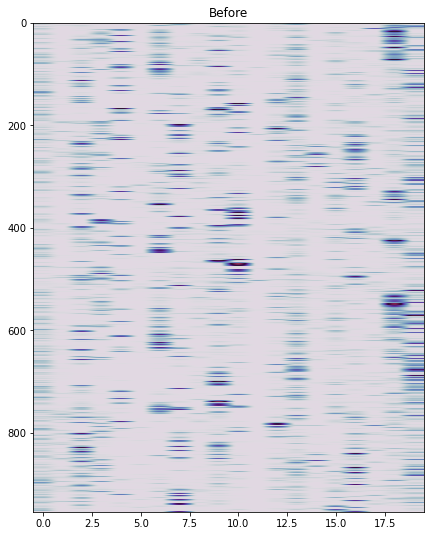

In [84]:
plt.figure(figsize=(7, 9))
plt.imshow(topics_before, cmap='twilight', aspect='auto')
plt.title('Before')
plt.show()

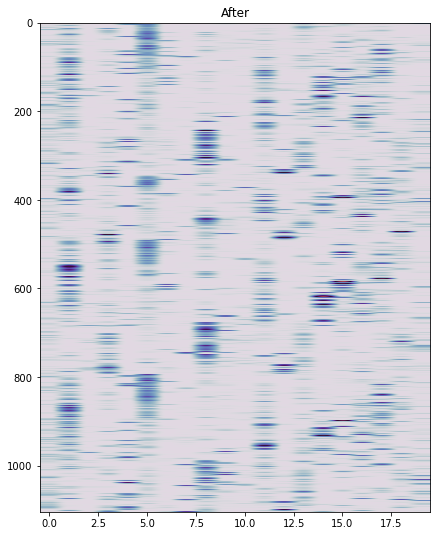

In [85]:
plt.figure(figsize=(7, 9))
plt.imshow(topics_after, cmap='twilight', aspect='auto')
plt.title('After')
plt.show()

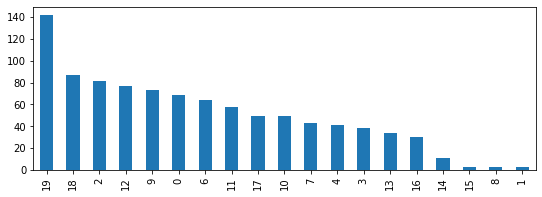

In [63]:
pd.Series(np.argmax(topics_before, axis=1)).value_counts().plot(kind='bar', figsize=(9, 3))

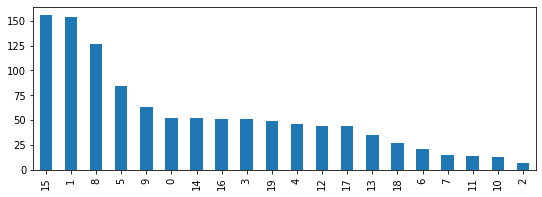

In [64]:
pd.Series(np.argmax(topics_after, axis=1)).value_counts().plot(kind='bar', figsize=(9, 3))